## Домашнее задание
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится) и посчитать метрики качества (roc auc, pr/rec/f1, logloss)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)
### Ссылки:
https://arxiv.org/pdf/1811.04820.pdf<br>
https://habr.com/ru/company/JetBrains-education/blog/512032/<br>
https://en.wikipedia.org/wiki/Bootstrap_aggregating<br>
https://www.cs.uic.edu/~liub/publications/EMNLP-2010-no-negative.pdf<br>
https://towardsdatascience.com/lookalikes-finding-needles-in-a-haystack-683bae8fdfff

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

Данные: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing<br>
Attribute Information:

Input variables:
#### bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
#### related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
#### other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
#### social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as catb
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(31415)

In [3]:
data = pd.read_csv('bank/bank.csv', ';')
print(data.shape)
data.head(3)

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no


In [4]:
data = data.rename(columns={'y': 'target'})

In [5]:
data['target'].value_counts()

no     4000
yes     521
Name: target, dtype: int64

In [6]:
data['target'] = list(map(lambda x: 0 if x=='no' else 1, data['target']))
data.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0


У нас есть 16 признаков и 1 целевая переменная (бинарная) - нужно определить сделает ли клиент срочный вклад

In [7]:
print(data.shape)

(4521, 17)


2. сделать feature engineering

Признаки 'day' и 'month' удалим, так как они не несут особой смысловой нагрузки. Признак 'duration' покрывает данные признаки.

In [8]:
data = data.drop(['day','month'], axis=1)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 15 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
target       4521 non-null int64
dtypes: int64(7), object(8)
memory usage: 529.9+ KB


In [10]:
target_feature = 'target'
cat_features = data.copy().select_dtypes(include=['object']).columns
print(f'cat_features: {cat_features}')
num_features = data.copy().select_dtypes(exclude=['object']).drop([target_feature], axis=1).columns
print(f'num_features: {num_features}')

cat_features: Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'poutcome'],
      dtype='object')
num_features: Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


In [11]:
data.describe()

,age,balance,duration,campaign,pdays,previous,target
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,263.961292,2.793630,39.766645,0.542579,0.115240
std,10.576211,3009.638142,259.856633,3.109807,100.121124,1.693562,0.319347
min,19.000000,-3313.000000,4.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,69.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,444.000000,185.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,1480.000000,329.000000,3.000000,-1.000000,0.000000,0.000000
max,87.000000,71188.000000,3025.000000,50.000000,871.000000,25.000000,1.000000


In [12]:
target = data[target_feature]
train_data = pd.concat([data.drop(['job', 'marital', 'education', 
                                  'default', 'housing', 'loan', 
                                  'contact', 'poutcome','target'], axis=1), 
                          pd.get_dummies(data['job'], prefix='job'),
                          pd.get_dummies(data['marital'], prefix='marital'),
                          pd.get_dummies(data['education'], prefix='education'),
                          pd.get_dummies(data['default'], prefix='default'),
                          pd.get_dummies(data['housing'], prefix='housing'),
                          pd.get_dummies(data['loan'], prefix='loan'),
                          pd.get_dummies(data['contact'], prefix='contact'),
                          pd.get_dummies(data['poutcome'], prefix='poutcome'),
                          target
                         ], 1)

In [13]:
train_data.head()

,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,target
0,30,1787,79,1,-1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
1,33,4789,220,1,339,4,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
2,35,1350,185,1,330,1,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
3,30,1476,199,4,-1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
4,59,0,226,1,-1,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0


Масштабирование делать не будем, так как будем использовать catboost.

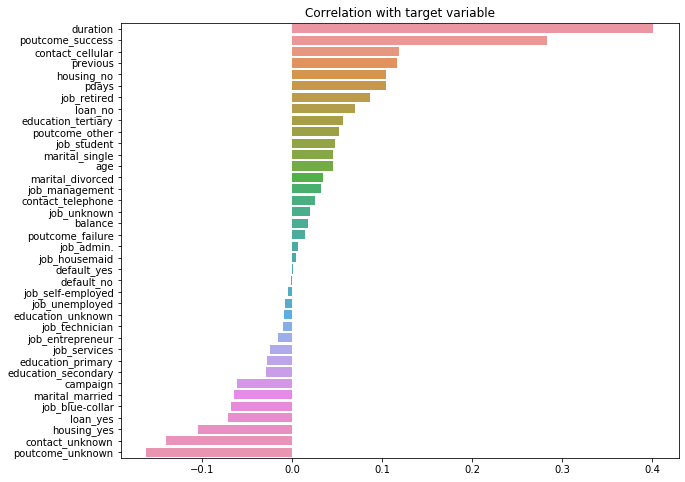

In [14]:
corr_with_target = train_data.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

3. обучить любой классификатор (какой вам нравится) и посчитать метрики качества (roc auc, pr/rec/f1, logloss)

In [15]:
disbalance = train_data[target_feature].value_counts()[0] / train_data[target_feature].value_counts()[1]
disbalance

7.677543186180422

In [16]:
# Разбиваем выборку на тренировочную и тестовую части и обучаем модель
from sklearn.model_selection import train_test_split

x_data = train_data.iloc[:,:-1]
y_data = train_data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [17]:
train_pool = catb.Pool(
    x_train,
    y_train,
)

test_pool = catb.Pool(
    x_test,
    y_test,
) 

params_model = {
    #'eval_metric': 'F1',
    #'class_weights':[1, disbalance],
    'silent': True,
    #'one_hot_max_size': 15,
    'early_stopping_rounds': 20,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

cb = catb.CatBoostClassifier(**params_model, random_state=9)
cb.fit(train_pool, eval_set=test_pool)
#y_train_pred = cb.predict(x_train)
y_test_pred = cb.predict(x_test)
y_test_pred_proba = cb.predict_proba(x_test).T[1]

In [18]:
# Plot the class probabilities for the unlabeled samples
def plot_precision_recall(precision, recall, th):
    fig = plt.figure(figsize=(6, 4))

    f1s = precision[:-1]*recall[:-1]
    plt.plot(th, f1s, linewidth=2, alpha=0.5)
    best_th = np.argmax(f1s)
    plt.plot(th[best_th], f1s[best_th], c='r', marker='o')
    plt.plot([th[best_th], th[best_th]], [0.0,f1s[best_th] ], 'r--')
    plt.plot([0.0, th[best_th]], [f1s[best_th], f1s[best_th] ], 'r--')
    plt.annotate('Pre: %0.3f, Rec: %0.3f' %(precision[best_th], recall[best_th]), 
                 xy=(th[best_th]+ 0.01, f1s[best_th]-0.05))
    plt.ylabel('F1 score')
    plt.xlabel('Probability threshold')
    plt.grid()

Classification results:
f1: 57.014%
roc: 87.116%
recall: 60.577%
precision: 53.846%
log_loss: 0.2483815729958655


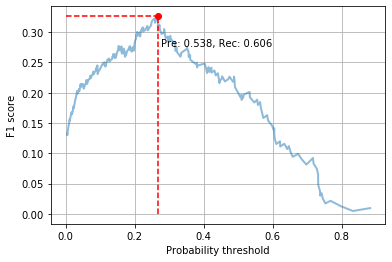

In [19]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, log_loss

results = pd.DataFrame()
results['type'] = []
results['threshold'] = []
results['Precision'] = []
results['Recall'] = []
results['F-Score'] = []
results['roc_auc'] = []
results['log_loss'] = []

def evaluate_results(y_test, y_predict, y_predict_proba, results, stype):
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_predict_proba)
    fscore = (2 * precision * recall) / (precision + recall)
    #print(precision, recall)
    ix = np.argmax(fscore)
    
    print('Classification results:')
    f1 = fscore[ix]
    print("f1: %.3f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict_proba)
    print("roc: %.3f%%" % (roc * 100.0)) 
    rec = recall[ix]
    print("recall: %.3f%%" % (rec * 100.0)) 
    prc = precision[ix]
    print("precision: %.3f%%" % (prc * 100.0)) 
    log = log_loss(y_test, y_predict_proba)
    print(f"log_loss: {log}")
    
    results = results.append({'type': stype, 
                'threshold': thresholds[ix],
                'Precision': prc,
                'Recall': rec,
                'F-Score': f1,
                'roc_auc': roc,
                'log_loss': log},
                ignore_index=True)
    
    plot_precision_recall(precision, recall, thresholds)
    
    return results

    
results = evaluate_results(y_test, y_test_pred, y_test_pred_proba, results, 'simple catboost')

4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

PU learning: Представим, что нам неизвестны негативы и часть позитивов (25%)

In [20]:
mod_data = train_data.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 131/521 as positives and unlabeling the rest


In [21]:
# Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    4390
 1     131
Name: class_test, dtype: int64


We now have just 131 positive samples labeled as 1 in the 'class_test' col while the rest is unlabeled as -1.

Recall that col 'target' still holds the actual label

In [22]:
mod_data.head(10)

,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,target,class_test
0,30,1787,79,1,-1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,-1
1,33,4789,220,1,339,4,0,0,0,0,...,1,1,0,0,1,0,0,0,0,-1
2,35,1350,185,1,330,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,-1
3,30,1476,199,4,-1,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,-1
4,59,0,226,1,-1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,-1
5,35,747,141,2,176,3,0,0,0,0,...,0,1,0,0,1,0,0,0,0,-1
6,36,307,341,1,330,2,0,0,0,0,...,0,1,0,0,0,1,0,0,0,-1
7,39,147,151,2,-1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,-1
8,41,221,57,2,-1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,-1
9,43,-88,313,1,147,2,0,0,0,0,...,1,1,0,0,1,0,0,0,0,-1


In [23]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

5. применить random negative sampling для построения классификатора в новых условиях

### random negative sampling

In [24]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(131, 40) (131, 40)


In [25]:
train_pool_2 = catb.Pool(
    sample_train.iloc[:,:-2].values,
    sample_train.iloc[:,-2].values,
)

test_pool_2 = catb.Pool(
    sample_train.iloc[:,:-2].values,
    sample_train.iloc[:,-2].values,
) 

params_model = {
    #'eval_metric': 'F1',
    #'class_weights':[1, disbalance],
    'silent': True,
    #'one_hot_max_size': 15,
    'early_stopping_rounds': 20,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

cb_2 = catb.CatBoostClassifier(**params_model, random_state=9)
cb_2.fit(train_pool_2, eval_set=test_pool_2)
#y_train_pred_2 = cb_2.predict(sample_test.iloc[:,:-2].values)
y_test_pred_2 = cb_2.predict(sample_test.iloc[:,:-2].values)
y_test_pred_proba_2 = cb_2.predict_proba(sample_test.iloc[:,:-2].values).T[1]

Classification results:
f1: 47.884%
roc: 87.075%
recall: 51.969%
precision: 44.395%
log_loss: 0.6048488987941367


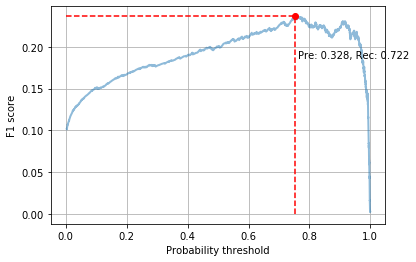

In [26]:
results = evaluate_results(sample_test.iloc[:,-2].values, y_test_pred_2, y_test_pred_proba_2, results, 'random negative sampling 25%')

6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)

In [27]:
results

,type,threshold,Precision,Recall,F-Score,roc_auc,log_loss
0,simple catboost,0.266652,0.538462,0.605769,0.570136,0.871159,0.248382
1,random negative sampling 25%,0.916793,0.443946,0.519685,0.478839,0.870746,0.604849


7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

#### PU learning: Представим, что нам неизвестны негативы и часть позитивов (15%)

In [28]:
mod_data = train_data.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.15 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 79/521 as positives and unlabeling the rest


In [29]:
# Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    4442
 1      79
Name: class_test, dtype: int64


In [30]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

In [31]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(79, 40) (79, 40)


In [32]:
train_pool_3 = catb.Pool(
    sample_train.iloc[:,:-2].values,
    sample_train.iloc[:,-2].values,
)

test_pool_3 = catb.Pool(
    sample_train.iloc[:,:-2].values,
    sample_train.iloc[:,-2].values,
) 

params_model = {
    #'eval_metric': 'F1',
    #'class_weights':[1, disbalance],
    'silent': True,
    #'one_hot_max_size': 15,
    'early_stopping_rounds': 20,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

cb_3 = catb.CatBoostClassifier(**params_model, random_state=9)
cb_3.fit(train_pool_3, eval_set=test_pool_3)
#y_train_pred_3 = cb_3.predict(sample_test.iloc[:,:-2].values)
y_test_pred_3 = cb_3.predict(sample_test.iloc[:,:-2].values)
y_test_pred_proba_3 = cb_3.predict_proba(sample_test.iloc[:,:-2].values).T[1]

Classification results:
f1: 45.088%
roc: 83.842%
recall: 50.115%
precision: 40.977%
log_loss: 0.684325041479899


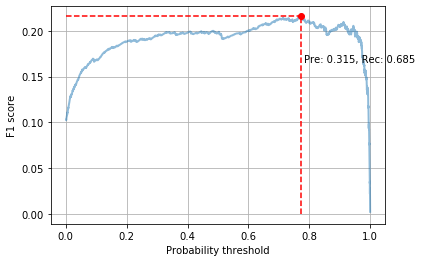

In [33]:
results = evaluate_results(sample_test.iloc[:,-2].values, y_test_pred_3, y_test_pred_proba_3, results, 'random negative sampling 15%')

#### PU learning: Представим, что нам неизвестны негативы и часть позитивов (50%)

In [34]:
mod_data = train_data.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.5 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 261/521 as positives and unlabeling the rest


In [35]:
# Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    4260
 1     261
Name: class_test, dtype: int64


In [36]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

In [37]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(261, 40) (261, 40)


In [38]:
train_pool_4 = catb.Pool(
    sample_train.iloc[:,:-2].values,
    sample_train.iloc[:,-2].values,
)

test_pool_4 = catb.Pool(
    sample_train.iloc[:,:-2].values,
    sample_train.iloc[:,-2].values,
) 

params_model = {
    #'eval_metric': 'F1',
    #'class_weights':[1, disbalance],
    'silent': True,
    #'one_hot_max_size': 15,
    'early_stopping_rounds': 20,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

cb_4 = catb.CatBoostClassifier(**params_model, random_state=9)
cb_4.fit(train_pool_4, eval_set=test_pool_4)
#y_train_pred_4 = cb_4.predict(sample_test.iloc[:,:-2].values)
y_test_pred_4 = cb_4.predict(sample_test.iloc[:,:-2].values)
y_test_pred_proba_4 = cb_4.predict_proba(sample_test.iloc[:,:-2].values).T[1]

Classification results:
f1: 41.007%
roc: 87.531%
recall: 46.531%
precision: 36.656%
log_loss: 0.5028850778913201


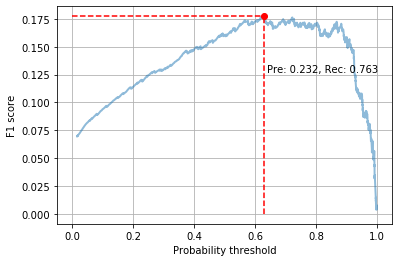

In [39]:
results = evaluate_results(sample_test.iloc[:,-2].values, y_test_pred_4, y_test_pred_proba_4, results, 'random negative sampling 50%')

In [40]:
results

,type,threshold,Precision,Recall,F-Score,roc_auc,log_loss
0,simple catboost,0.266652,0.538462,0.605769,0.570136,0.871159,0.248382
1,random negative sampling 25%,0.916793,0.443946,0.519685,0.478839,0.870746,0.604849
2,random negative sampling 15%,0.944476,0.409774,0.501149,0.450879,0.838418,0.684325
3,random negative sampling 50%,0.882976,0.366559,0.465306,0.410072,0.875311,0.502885


Если смотреть на f-score, то получилось, что 25% - как золотая середина, все, что меньше или больше - хуже по качеству. Если смотреть на roc_auc, то получили, что, чем больше позитивов мы оставляем размеченными, тем лучше качество.